# Multi-VAE

이번 미션에서는 [Variational Autoencoders for Collaborative Filtering](https://arxiv.org/abs/1802.05814)에서 제안된 Multi-VAE 기반의 협업 필터링을 구현해보도록 하겠습니다. 다양한 Auto-Encoder 기반의 협업필터링이 제안된 이후에, 가장 강력하다고 평가받는 VAE 기반의 협업 필터링을 이해하는 시간을 갖도록 하겠습니다.

- 이 미션은 다음 [코드](https://github.com/younggyoseo/vae-cf-pytorch)를 기반으로 작성되었습니다. 바로 코드를 확인해보지 마시고, 최대한 직접 작성을 해보세요!
- 이 미션에서 중요한 부분은 모델 부분입니다. 데이터 전처리 부분은 가볍게 훑어 보시고, 모델 부분을 집중해주세요!
- 완성을 해야할 부분은 TODO로 표시가 되어있습니다.

## 1. 초기 세팅

In [1]:
## 전처리과정에서 pandas의 버전에 다르게 동작하는 경향이 보여, 이 미션에서는 아래 버전으로 사용하도록하겠습니다.
!pip install pandas==1.0.1

In [2]:
import argparse
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt

In [3]:
## 각종 파라미터 세팅
parser = argparse.ArgumentParser(description='PyTorch Variational Autoencoders for Collaborative Filtering')

# data path
parser.add_argument('--data_path', type=str, default='../../input/data/train/',
                    help='Movielens dataset location')
parser.add_argument('--model_path', type=str, default='model/',
                    help='path to save/load the model')
parser.add_argument('--submit_path', type=str, default='output/',
                    help='path to save the submission')
parser.add_argument('--load_model', type=str, default='multi-dae.pt',
                    help='model.pt file to load the model')

# hyper parameter
parser.add_argument('--lr', type=float, default=1e-4,
                    help='initial learning rate')
parser.add_argument('--wd', type=float, default=0.01,
                    help='weight decay coefficient')
parser.add_argument('--batch_size', type=int, default=500,
                    help='batch size')
parser.add_argument('--total_anneal_steps', type=int, default=200000,
                    help='the total number of gradient updates for annealing')
parser.add_argument('--anneal_cap', type=float, default=0.2,
                    help='largest annealing parameter')

# etc
parser.add_argument('--epochs', type=int, default=400,
                    help='upper epoch limit')
parser.add_argument('--cuda', action='store_true',
                    help='use CUDA')
parser.add_argument('--log_interval', type=int, default=100, metavar='N',
                    help='report interval')
parser.add_argument('--seed', type=int, default=42,
                    help='random seed')

args = parser.parse_args([])

# Set the random seed manually for reproductibility.
torch.manual_seed(args.seed)

#만약 GPU가 사용가능한 환경이라면 GPU를 사용
if torch.cuda.is_available():
    args.cuda = True

device = torch.device("cuda" if args.cuda else "cpu")
device

device(type='cuda')

## 2. 데이터 전처리

이 부분에서 진행되는 과정은 저희가 일반적으로 알고있는 MovieLens (user, item, timestamp)데이터를 전처리하는 과정입니다. 전처리 과정의 다양한 옵션들을 구성하기 위해 약간 복잡하게 되었지만, 
결과적으로는, 유저들의 특정한 아이템들을 따로 분리를 해서, 그 분리된 값을 모델이 예측할 수 있냐를 확인하기 위한 전처리 과정이라고 보시면 되겠습니다.
실제로 나오는 데이터셋을 확인하면 더욱 이해가 빠를것입니다.

In [4]:
import os
import pandas as pd
from scipy import sparse
import numpy as np

def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()

    return count

# 특정한 횟수 이상의 리뷰가 존재하는(사용자의 경우 min_uc 이상, 아이템의 경우 min_sc이상) 
# 데이터만을 추출할 때 사용하는 함수입니다.
# 현재 데이터셋에서는 결과적으로 원본그대로 사용하게 됩니다.
def filter_triplets(tp, min_uc=5, min_sc=0):
    if min_sc > 0:
        itemcount = get_count(tp, 'item')
        tp = tp[tp['item'].isin(itemcount.index[itemcount >= min_sc])]

    if min_uc > 0:
        usercount = get_count(tp, 'user')
        tp = tp[tp['user'].isin(usercount.index[usercount >= min_uc])]

    usercount, itemcount = get_count(tp, 'user'), get_count(tp, 'item')
    return tp, usercount, itemcount

#훈련된 모델을 이용해 검증할 데이터를 분리하는 함수입니다.
#100개의 액션이 있다면, 그중에 test_prop 비율 만큼을 비워두고, 그것을 모델이 예측할 수 있는지를
#확인하기 위함입니다.
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('user')
    tr_list, te_list = list(), list()

    np.random.seed(args.seed)
    
    for _, group in data_grouped_by_user:
        n_items_u = len(group)
        
        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        
        else:
            tr_list.append(group)
    
    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)

    return data_tr, data_te

def numerize(tp, profile2id, show2id):
    uid = tp['user'].apply(lambda x: profile2id[x])
    sid = tp['item'].apply(lambda x: show2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [5]:
print("Load and Preprocess Movielens dataset")
# Load Data
DATA_DIR = args.data_path
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'train_ratings.csv'), header=0)
print("원본 데이터\n", raw_data.head())

# Filter Data
raw_data, user_activity, item_popularity = filter_triplets(raw_data, min_uc=5, min_sc=0)
#제공된 훈련데이터의 유저는 모두 5개 이상의 리뷰가 있습니다.
print("5번 이상의 리뷰가 있는 유저들로만 구성된 데이터\n",raw_data.head())

print("유저별 리뷰수\n",user_activity.head())
print("아이템별 리뷰수\n",item_popularity.head())

Load and Preprocess Movielens dataset


FileNotFoundError: [Errno 2] File ../../data/train/train_ratings.csv does not exist: '../../data/train/train_ratings.csv'

In [ ]:
# Shuffle User Indices
unique_uid = user_activity.index
print("(BEFORE) unique_uid:",unique_uid[:5])
np.random.seed(args.seed)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]
print("(AFTER) unique_uid:",unique_uid[:5])

n_users = unique_uid.size #31360
n_heldout_users = int(0.1 * n_users)


# Split Train/Validation/Test User Indices
tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

#주의: 데이터의 수가 아닌 사용자의 수입니다!
print("훈련 데이터에 사용될 사용자 수:", len(tr_users))
print("검증 데이터에 사용될 사용자 수:", len(vd_users))
print("테스트 데이터에 사용될 사용자 수:", len(te_users))

(BEFORE) unique_uid: Int64Index([11, 14, 18, 25, 31], dtype='int64', name='user')
(AFTER) unique_uid: Int64Index([81259, 11986, 67552, 127325, 115853], dtype='int64', name='user')
훈련 데이터에 사용될 사용자 수: 25088
검증 데이터에 사용될 사용자 수: 3136
테스트 데이터에 사용될 사용자 수: 3136


In [ ]:
##훈련 데이터에 해당하는 아이템들
#Train에는 전체 데이터를 사용합니다.
train_plays = raw_data.loc[raw_data['user'].isin(tr_users)]

##아이템 ID
unique_sid = pd.unique(train_plays['item'])

show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

#Validation과 Test에는 input으로 사용될 tr 데이터와 정답을 확인하기 위한 te 데이터로 분리되었습니다.
vad_plays = raw_data.loc[raw_data['user'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['item'].isin(unique_sid)]
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

test_plays = raw_data.loc[raw_data['user'].isin(te_users)]
test_plays = test_plays.loc[test_plays['item'].isin(unique_sid)]
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)


train_data = numerize(train_plays, profile2id, show2id)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)


vad_data_tr = numerize(vad_plays_tr, profile2id, show2id)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

vad_data_te = numerize(vad_plays_te, profile2id, show2id)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

test_data_tr = numerize(test_plays_tr, profile2id, show2id)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

test_data_te = numerize(test_plays_te, profile2id, show2id)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

print("Done!")

Done!


In [ ]:
#데이터 셋 확인
print(train_data.head())
print(vad_data_tr.head())
print(vad_data_te.head())
# print(test_data_tr.head())
# print(test_data_te.head())

     uid  sid
0  13266    0
1  13266    1
2  13266    2
3  13266    3
4  13266    4
        uid   sid
2133  28125   887
2134  28125  1162
2135  28125  1418
2137  28125   320
2138  28125   742
        uid   sid
2132  28125   484
2136  28125   515
2142  28125   265
2144  28125   286
2150  28125  1420


## 3. 데이터 로더 설정

In [ ]:

class DataLoader():
    '''
    Load Movielens dataset
    '''
    def __init__(self, path):
        
        self.pro_dir = os.path.join(path, 'pro_sg')
        assert os.path.exists(self.pro_dir), "Preprocessed files do not exist."

        self.n_items = self.load_n_items()
    
    def load_data(self, datatype='train'):
        if datatype == 'train':
            return self._load_train_data()
        elif datatype == 'validation':
            return self._load_tr_te_data(datatype)
        elif datatype == 'test':
            return self._load_tr_te_data(datatype)
        else:
            raise ValueError("datatype should be in [train, validation, test]")
        
    def load_n_items(self):
        unique_sid = list()
        with open(os.path.join(self.pro_dir, 'unique_sid.txt'), 'r') as f:
            for line in f:
                unique_sid.append(line.strip())
        n_items = len(unique_sid)
        return n_items
    
    def _load_train_data(self):
        path = os.path.join(self.pro_dir, 'train.csv')
        
        tp = pd.read_csv(path)
        n_users = tp['uid'].max() + 1

        rows, cols = tp['uid'], tp['sid']
        data = sparse.csr_matrix((np.ones_like(rows),
                                 (rows, cols)), dtype='float64',
                                 shape=(n_users, self.n_items))
        return data
    
    def _load_tr_te_data(self, datatype='test'):
        tr_path = os.path.join(self.pro_dir, '{}_tr.csv'.format(datatype))
        te_path = os.path.join(self.pro_dir, '{}_te.csv'.format(datatype))

        tp_tr = pd.read_csv(tr_path)
        tp_te = pd.read_csv(te_path)

        start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
        end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

        rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
        rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

        data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                                    (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        data_te = sparse.csr_matrix((np.ones_like(rows_te),
                                    (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        return data_tr, data_te

## 4. 모델정의



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np


#이미 완성된 MultiDAE의 코드를 참고하여 그 아래 MultiVAE의 코드를 완성해보세요!
class MultiDAE(nn.Module):
    """
    Container module for Multi-DAE.

    Multi-DAE : Denoising Autoencoder with Multinomial Likelihood
    See Variational Autoencoders for Collaborative Filtering
    https://arxiv.org/abs/1802.05814
    """

    def __init__(self, p_dims, q_dims=None, dropout=0.5):
        super(MultiDAE, self).__init__()
        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        self.p_dims[1] = self.p_dims[1] * 2
        self.dims = self.q_dims + self.p_dims[1:]
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.dims[:-1], self.dims[1:])])
        self.drop = nn.Dropout(dropout)
        
        self.init_weights()
    
    def forward(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i != len(self.layers) - 1:
                h = torch.tanh(h)
        return h

    def init_weights(self):
        for layer in self.layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)



class MultiVAE(nn.Module):
    """
    Container module for Multi-VAE.

    Multi-VAE : Variational Autoencoder with Multinomial Likelihood
    See Variational Autoencoders for Collaborative Filtering
    https://arxiv.org/abs/1802.05814
    """

    def __init__(self, p_dims, q_dims=None, dropout=0.5):
        super(MultiVAE, self).__init__()
        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        # Last dimension of q- network is for mean and variance
        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])
        
        self.drop = nn.Dropout(dropout)
        self.init_weights()
    
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def encode(self, input):
        h = F.normalize(input)
        h = self.drop(h)
        
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = torch.tanh(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = torch.tanh(h)
        return h

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)




def loss_function_vae(recon_x, x, mu, logvar, anneal=1.0):
    BCE = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    return BCE + anneal * KLD

def loss_function_dae(recon_x, x):
    BCE = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
    return BCE

In [ ]:
def sparse2torch_sparse(data):
    """
    Convert scipy sparse matrix to torch sparse tensor with L2 Normalization
    This is much faster than naive use of torch.FloatTensor(data.toarray())
    https://discuss.pytorch.org/t/sparse-tensor-use-cases/22047/2
    """
    samples = data.shape[0]
    features = data.shape[1]
    coo_data = data.tocoo()
    indices = torch.LongTensor([coo_data.row, coo_data.col])
    row_norms_inv = 1 / np.sqrt(data.sum(1))
    row2val = {i : row_norms_inv[i].item() for i in range(samples)}
    values = np.array([row2val[r] for r in coo_data.row])
    t = torch.sparse.FloatTensor(indices, torch.from_numpy(values).float(), [samples, features])
    return t

def naive_sparse2tensor(data):
    return torch.FloatTensor(data.toarray())


def train(model, criterion, optimizer, is_VAE = False):
    # Turn on training mode
    model.train()
    train_loss = 0.0
    start_time = time.time()
    global update_count

    np.random.shuffle(idxlist)
    
    for batch_idx, start_idx in enumerate(range(0, N, args.batch_size)):
        end_idx = min(start_idx + args.batch_size, N)
        data = train_data[idxlist[start_idx:end_idx]]
        data = naive_sparse2tensor(data).to(device)
        optimizer.zero_grad()

        if is_VAE:
          if args.total_anneal_steps > 0:
            anneal = min(args.anneal_cap, 
                            1. * update_count / args.total_anneal_steps)
          else:
              anneal = args.anneal_cap

          optimizer.zero_grad()
          recon_batch, mu, logvar = model(data)
          
          loss = criterion(recon_batch, data, mu, logvar, anneal)
        else:
          recon_batch = model(data)
          loss = criterion(recon_batch, data)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        update_count += 1

        if batch_idx % args.log_interval == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:4d}/{:4d} batches | ms/batch {:4.2f} | '
                    'loss {:4.2f}'.format(
                        epoch, batch_idx, len(range(0, N, args.batch_size)),
                        elapsed * 1000 / args.log_interval,
                        train_loss / args.log_interval))
            

            start_time = time.time()
            train_loss = 0.0


def evaluate(model, criterion, data_tr, data_te, is_VAE=False):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    n100_list = []
    r10_list = []
    r20_list = []
    r50_list = []
    
    with torch.no_grad():
        for start_idx in range(0, e_N, args.batch_size):
            end_idx = min(start_idx + args.batch_size, N)
            data = data_tr[e_idxlist[start_idx:end_idx]]
            heldout_data = data_te[e_idxlist[start_idx:end_idx]]

            data_tensor = naive_sparse2tensor(data).to(device)
            if is_VAE :
              
              if args.total_anneal_steps > 0:
                  anneal = min(args.anneal_cap, 
                                1. * update_count / args.total_anneal_steps)
              else:
                  anneal = args.anneal_cap

              recon_batch, mu, logvar = model(data_tensor)

              loss = criterion(recon_batch, data_tensor, mu, logvar, anneal)

            else :
              recon_batch = model(data_tensor)
              loss = criterion(recon_batch, data_tensor)




            total_loss += loss.item()

            # Exclude examples from training set
            recon_batch = recon_batch.cpu().numpy()
            recon_batch[data.nonzero()] = -np.inf

            n100 = NDCG_binary_at_k_batch(recon_batch, heldout_data, 100)
            r10 = Recall_at_k_batch(recon_batch, heldout_data, 10)
            r20 = Recall_at_k_batch(recon_batch, heldout_data, 20)
            r50 = Recall_at_k_batch(recon_batch, heldout_data, 50)

            n100_list.append(n100)
            r10_list.append(r10)
            r20_list.append(r20)
            r50_list.append(r50)
 
    total_loss /= len(range(0, e_N, args.batch_size))
    n100_list = np.concatenate(n100_list)
    r10_list = np.concatenate(r10_list)
    r20_list = np.concatenate(r20_list)
    r50_list = np.concatenate(r50_list)

    return total_loss, np.mean(n100_list), np.mean(r10_list), np.mean(r20_list), np.mean(r50_list)


## 5. Metric 정의

In [ ]:
!pip install bottleneck

In [ ]:
import bottleneck as bn
import numpy as np

def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    Normalized Discounted Cumulative Gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)

    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG


def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

## 6. MultiDAE 테스트

In [ ]:
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

dae_path = args.model_path + "multi-dae.pt"
vae_path = args.model_path + "multi-vae.pt"

In [ ]:

###############################################################################
# Load data
###############################################################################

loader = DataLoader(args.data_path)

n_items = loader.load_n_items()
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
test_data_tr, test_data_te = loader.load_data('test')

N = train_data.shape[0]
idxlist = list(range(N))

###############################################################################
# Build the model
###############################################################################

p_dims = [100, 1200, n_items]
model = MultiDAE(p_dims).to(device)

optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)
criterion = loss_function_dae

###############################################################################
# Training code
###############################################################################

best_r10 = -np.inf  #best_n100 = -np.inf
update_count = 0

In [ ]:
for epoch in range(1, args.epochs + 1):
    epoch_start_time = time.time()
    train(model, criterion, optimizer, is_VAE=False)
    val_loss, n100, r10, r20, r50 = evaluate(model, criterion, vad_data_tr, vad_data_te, is_VAE=False)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:4.2f}s | valid loss {:4.2f} | '
            'n100 {:5.3f} | r10 {:5.3f} | r20 {:5.3f} | r50 {:5.3f}'.format(
                epoch, time.time() - epoch_start_time, val_loss,
                n100, r10, r20, r50))
    print('-' * 89)

    n_iter = epoch * len(range(0, N, args.batch_size))


    # Save the model if the n100 is the best we've seen so far.
    if r10 > best_r10:    #n100 > best_n100
        with open(dae_path, 'wb') as f:
            torch.save(model, f)
        best_r10 = r10    #best_n100 = n100



# Load the best saved model.
with open(dae_path, 'rb') as f:
    model = torch.load(f)

# Run on test data.
test_loss, n100, r10, r20, r50 = evaluate(model, criterion, test_data_tr, test_data_te, is_VAE=False)
print('=' * 89)
print('| End of training | test loss {:4.2f} | n100 {:4.2f} | r10 {:4.2f} | r20 {:4.2f} | '
        'r50 {:4.2f}'.format(test_loss, n100, r10, r20, r50))
print('=' * 89)

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 1.86s | valid loss 1049.51 | n100 0.214 | r10 0.142 | r20 0.136 | r50 0.192
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 1.83s | valid loss 1032.86 | n100 0.269 | r10 0.211 | r20 0.196 | r50 0.240
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 1.80s | valid loss 1026.56 | n100 0.269 | r10 0.212 | r20 0.194 | r50 0.240
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 1.89s | valid loss 1023.60 | n100 

## 7. MultiVAE 테스트 (TODO)

위의 MultiVAE 모델 코드, train, evaluate 함수를 완성하여, 아래 훈련 코드가 정상적으로 동작하도록 해보세요!

In [ ]:

# ###############################################################################
# # Load data
# ###############################################################################

# loader = DataLoader(args.data_path)

# n_items = loader.load_n_items()
# train_data = loader.load_data('train')
# vad_data_tr, vad_data_te = loader.load_data('validation')
# test_data_tr, test_data_te = loader.load_data('test')

# N = train_data.shape[0]
# idxlist = list(range(N))

# ###############################################################################
# # Build the model
# ###############################################################################

# p_dims = [100, 1200, n_items]
# model = MultiVAE(p_dims).to(device)

# optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)
# criterion = loss_function_vae

# ###############################################################################
# # Training code
# ###############################################################################

# best_r10 = -np.inf  #best_n100 = -np.inf
# update_count = 0

In [ ]:
# for epoch in range(1, args.epochs + 1):
#     epoch_start_time = time.time()
#     train(model, criterion, optimizer, is_VAE=True)
#     val_loss, n100, r10, r20, r50 = evaluate(model, criterion, vad_data_tr, vad_data_te, is_VAE=True)
#     print('-' * 89)
#     print('| end of epoch {:3d} | time: {:4.2f}s | valid loss {:4.2f} | '
#             'n100 {:5.3f} | r10 {:5.3f} | r20 {:5.3f} | r50 {:5.3f}'.format(
#                 epoch, time.time() - epoch_start_time, val_loss,
#                 n100, r10, r20, r50))
#     print('-' * 89)

#     n_iter = epoch * len(range(0, N, args.batch_size))


#     # Save the model if the n100 is the best we've seen so far.
#     if r10 > best_r10:    #n100 > best_n100
#         with open(vae_path, 'wb') as f:
#             torch.save(model, f)
#         best_r10 = r10    #best_n100 = n100



# # Load the best saved model.
# with open(vae_path, 'rb') as f:
#     model = torch.load(f)

# # Run on test data.
# test_loss, n100, r10, r20, r50 = evaluate(model, criterion, test_data_tr, test_data_te, is_VAE=True)
# print('=' * 89)
# print('| End of training | test loss {:4.2f} | n100 {:4.2f} | r10 {:4.2f} | r20 {:4.2f} | '
#         'r50 {:4.2f}'.format(test_loss, n100, r10, r20, r50))
# print('=' * 89)

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 1.99s | valid loss 1101.31 | n100 0.204 | r10 0.137 | r20 0.140 | r50 0.188
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 1.98s | valid loss 1034.10 | n100 0.267 | r10 0.208 | r20 0.194 | r50 0.239
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 1.95s | valid loss 1031.54 | n100 0.268 | r10 0.210 | r20 0.194 | r50 0.240
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 2.02s | valid loss 1029.56 | n100 

## 8. 제출 파일 생성

In [ ]:
if not os.path.exists(args.submit_path):
    os.makedirs(args.submit_path)

In [ ]:
###############################################################################

raw_data = pd.read_csv(os.path.join(DATA_DIR, 'train_ratings.csv'), header=0)

inference_data = numerize(raw_data, profile2id, show2id)
n_items = inference_data['sid'].nunique()

In [ ]:
start_idx = inference_data['uid'].min()
end_idx = inference_data['uid'].max()

rows_if, cols_if = inference_data['uid'] - start_idx, inference_data['sid']

inference_sdata = sparse.csr_matrix((np.ones_like(rows_if), (rows_if, cols_if)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

In [ ]:
###############################################################################
# Load the model
###############################################################################

p_dims = [200, 600, n_items]

dmodel = MultiDAE(p_dims).to(device)
with open(dae_path, 'rb') as f:
    dmodel = torch.load(f)

# vmodel = MultiVAE(p_dims).to(device)
# with open(vae_path, 'rb') as f:
#     vmodel = torch.load(f)

In [ ]:
###############################################################################
# Inference
###############################################################################
dmodel.eval()
# vmodel.eval()

drecon_list = []
vrecon_list = []
update_count = 0
e_idxlist = list(range(inference_sdata.shape[0]))
e_N = inference_sdata.shape[0]

with torch.no_grad():
    for start_idx in range(0, e_N, args.batch_size):
        end_idx = min(start_idx + args.batch_size, e_N)
        data = inference_sdata[e_idxlist[start_idx:end_idx]]
        data_tensor = naive_sparse2tensor(data).to(device)
        # VAE
        # if args.total_anneal_steps > 0:
        #     anneal = min(args.anneal_cap, 
        #         1. * update_count / args.total_anneal_steps)
        # else:
        #     anneal = args.anneal_cap
        # vrecon_batch, mu, logvar = vmodel(data_tensor)
        # DAE
        drecon_batch = dmodel(data_tensor)

        drecon_batch = drecon_batch.cpu().numpy()
        drecon_batch[data.nonzero()] = -np.inf #, 분포 분석을 위해 교체
        drecon_list.append(drecon_batch)

        # vrecon_batch = vrecon_batch.cpu().numpy()
        # vrecon_batch[data.nonzero()] = -10  # -np.inf, 분포 분석을 위해 교체
        # vrecon_list.append(vrecon_batch)
        
drecon_list = np.concatenate(drecon_list)
vrecon_list = np.concatenate(vrecon_list)

In [ ]:
# np.argsort: 작은 값부터 순서대로 인덱스 반환
dpred = [[], []]
for u, i in enumerate(drecon_list):
    dpred[0].append([u]*10)
    dpred[1].append(np.argsort(i)[-20:])
dpred[0] = np.concatenate(dpred[0])
dpred[1] = np.concatenate(dpred[1])

# vpred = [[], []]
# for u, i in enumerate(vrecon_list):
#     vpred[0].append([u]*10)
#     vpred[1].append(np.argsort(i)[-10:])
# vpred[0] = np.concatenate(vpred[0])
# vpred[1] = np.concatenate(vpred[1])

In [ ]:
dsubmit = pd.DataFrame(data={'ui': dpred[0], 'ii': dpred[1]}, columns=['ui', 'ii'])
# vsubmit = pd.DataFrame(data={'ui': vpred[0], 'ii': vpred[1]}, columns=['ui', 'ii'])

In [ ]:
#유저, 아이템 디코딩(원래값으로 변환)
rshow2id = dict((i, sid) for (i, sid) in enumerate(unique_sid))
rprofile2id = dict((i, pid) for (i, pid) in enumerate(unique_uid))
def reverse_numerize(tp, rshow2id, rprofile2id):
    user = tp['ui'].apply(lambda x: rprofile2id[x])
    item = tp['ii'].apply(lambda x: rshow2id[x])
    return pd.DataFrame(data={'user': user, 'item': item}, columns=['user', 'item'])

In [ ]:
dsubmit_df = reverse_numerize(dsubmit, rshow2id, rprofile2id)
# vsubmit_df = reverse_numerize(vsubmit, rshow2id, rprofile2id)

In [ ]:
dsubmit_df.sort_values(by='user')

,user,item
132668,11,4963
132669,11,5418
132667,11,2167
132666,11,1370
132665,11,733
...,...,...
49275,138493,32587
49276,138493,1270
49277,138493,2502
49279,138493,33794


In [ ]:
dsubmit_df.to_csv(args.submit_path+"multi-dae_submission.csv", index=False)
# vsubmit_df.to_csv(args.submit_path+"multi-vae_submission.csv", index=False)

## 결과 분석

In [ ]:
len(drecon_batch[0])

6807

(array([203.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,  11.,  23.,
         44.,  78., 115., 175., 218., 327., 329., 384., 406., 426., 478.,
        414., 408., 360., 375., 291., 282., 238., 214., 171., 173., 163.,
        143., 119.,  74.,  68.,  60.,  26.,   9.]),
 array([-10.        ,  -9.64616871,  -9.29233646,  -8.93850517,
         -8.58467388,  -8.23084164,  -7.87701035,  -7.52317905,
         -7.16934729,  -6.81551552,  -6.46168423,  -6.10785246,
         -5.75402069,  -5.4001894 ,  -5.04635763,  -4.69252634,
         -4.33869457,  -3.98486304,  -3.63103151,  -3.27719975,
         -2.92336822,  -2.56953669,  -2.21570492,  -1.86187339,
         -1.50804186,  -1.15421033,  -0.80037868,  -0.44654709,
         -0.0927155 ,   0.26111609,   0.61494768,   0.96877927,
          1.32261086,   1.67644238,   2.03027391,   2.38410568,
          2.73793721,   3.09176874,   3.44560051,   3.79943204,
          4.15326357]),
 <BarContainer object of 40 artists>)

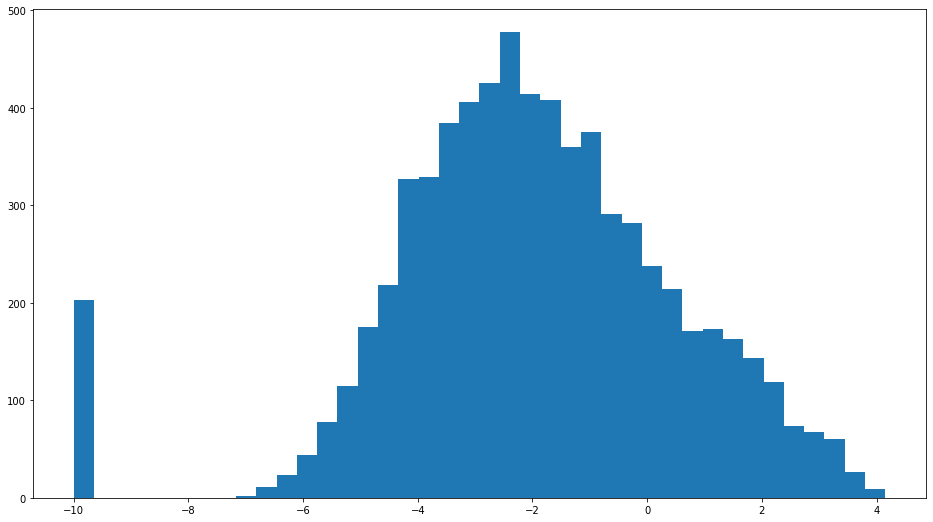

In [ ]:
plt.figure(figsize=(16,9))
plt.hist(drecon_batch[-1], 40)